In [11]:
import logging, sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, hamming_loss, f1_score, ConfusionMatrixDisplay
import subprocess
from tqdm.notebook import tqdm

In [2]:
cd AutoFolio

/home/guillaume/recimpute/Experiments/AutoFolio


In [3]:
from autofolio.facade.af_csv_facade import AFCsvFacade
from autofolio.autofolio import AutoFolio

In [4]:
cd ../../

/home/guillaume/recimpute


In [5]:
%load_ext autoreload
%autoreload 2
from Clustering.AbstractClustering import AbstractClustering
from Clustering.ShapeBasedClustering import ShapeBasedClustering
from Datasets.Dataset import Dataset
from Datasets.TrainingSet import TrainingSet
from Labeling.ImputationTechniques.ImputeBenchLabeler import ImputeBenchLabeler
from Labeling import AbstractLabeler
from FeaturesExtraction.TSFreshFeaturesExtractor import TSFreshFeaturesExtractor
from FeaturesExtraction.KiviatFeaturesExtractor import KiviatFeaturesExtractor
from FeaturesExtraction.KatsFeaturesExtractor import KatsFeaturesExtractor
from FeaturesExtraction.Catch22FeaturesExtractor import Catch22FeaturesExtractor
from FeaturesExtraction.TopologicalFeaturesExtractor import TopologicalFeaturesExtractor
from Utils.Utils import Utils

In [13]:
if not os.path.exists('Experiments/results'):
    os.makedirs('Experiments/results')

In [6]:
len(Dataset.CONF['USE_LIST'])

107

In [7]:
# init training and test sets
#AbstractClustering.CLUSTERS_APPENDIX = '_cassignments.csv'
#ShapeBasedClustering.CLUSTERS_FILENAMES_ID = '_sbc'
#AbstractLabeler.LABELS_APPENDIX = '_labels.csv'
#ImputeBenchLabeler.LABELS_FILENAMES_ID = '_ibl'
#TSFreshFeaturesExtracter.FEATURES_FILENAMES_ID = '_tsfresh'

CLUSTERER = ShapeBasedClustering()
DATASETS = Dataset.instantiate_from_dir(CLUSTERER)
LABELER = ImputeBenchLabeler.get_instance()
LABELER_PROPERTIES = LABELER.get_default_properties()
FEATURES_EXTRACTORS_MAP = { # maps the argument name to the actual class name
    #'Kiviat': KiviatFeaturesExtractor, 
    'TSFresh': TSFreshFeaturesExtractor,
    'Topological': TopologicalFeaturesExtractor,
    'Catch22': Catch22FeaturesExtractor,
    'Kats': KatsFeaturesExtractor,
}
FEATURES_EXTRACTORS = [fe.get_instance() for fe in FEATURES_EXTRACTORS_MAP.values()]
TRUE_LABELER_INFO = {}

training_set = TrainingSet(
    DATASETS, 
    CLUSTERER, 
    FEATURES_EXTRACTORS, 
    LABELER, LABELER_PROPERTIES,
    **TRUE_LABELER_INFO,
    force_generation=False,
)
#training_set.CONF['TEST_SET_RESERVATION_STRAT'] = 'ts_percentage'
#training_set.CONF['TEST_SIZE_PERCENTAGE'] = 0.2
#training_set.CONF['USE_CUSTOM_SPLIT_METHOD'] = False

Running clustering (if not done already).
Clustering: 0.00 seconds
Reserving a test set: 0.01 seconds
Running labeling & features extraction (if not done already).
Labeling & features extraction: 0.00 seconds


## Preparing files

In [8]:
f1_filename = 'perf.csv' # 'perf_toy.csv'
f2_filename = 'features.csv' # 'feats_toy.csv'
model_filename = 'autofolio_trained_mdl'

perf_fn = 'Experiments/results/autofolio_%s' % f1_filename
feat_fn = 'Experiments/results/autofolio_%s' % f2_filename
model_fn = 'Experiments/results/autofolio_%s' % model_filename

In [10]:
all_train_info, _ = training_set._load(data_to_load='train')

In [11]:
all_train_info.head(3)

,Label,Values__variance_larger_than_standard_deviation_tsfresh,Values__has_duplicate_max_tsfresh,Values__has_duplicate_min_tsfresh,Values__has_duplicate_tsfresh,Values__sum_values_tsfresh,Values__abs_energy_tsfresh,Values__mean_abs_change_tsfresh,Values__mean_change_tsfresh,Values__mean_second_derivative_central_tsfresh,...,diff1y_pacf5_kats,diff2y_pacf5_kats,seas_acf1_kats,seas_pacf1_kats,firstmin_ac_kats,firstzero_ac_kats,holt_alpha_kats,holt_beta_kats,Cluster ID,Data Set Name
New Time Series ID,,,,,,,,,,,,,,,,,,,,,
0,rosl,0.0,0.0,0.0,1.0,0.000000e+00,469.0,0.039177,-0.003795,0.000007,...,0.730759,0.141231,0.906554,0.001385,121,66,1.00000,0.714543,7935,Beef
1,svt,0.0,0.0,0.0,1.0,0.000000e+00,469.0,0.029620,0.000638,-0.000021,...,0.949076,0.264981,0.956766,-0.275313,79,49,1.00000,0.498895,7936,Beef
2,svt,0.0,0.0,0.0,0.0,-1.421085e-14,469.0,0.041692,-0.000424,-0.000013,...,0.958955,0.090892,0.900865,9.103534,65,54,0.98642,0.986420,7936,Beef


In [12]:
all_train_info.shape

(46071, 435)

In [13]:
def load_imputebench_results_per_cid(ds_name):
    labels_filename = LABELER._get_labels_filename(ds_name)
    all_benchmark_results = pd.read_csv(labels_filename, index_col='Cluster ID')

    # get each cluster's label from their benchmark results
    clusters_labels = []
    for cid, bench_res in all_benchmark_results.iterrows(): # for each cluster
        # convert bench_res to DataFrame
        benchmark_results = LABELER._convert_bench_res_to_df(bench_res.values[0])
        # get a ranked list of algorithms for this cluster (from best to worse)
        ranking_strat = ImputeBenchLabeler.CONF['BENCH_RES_AGG_AND_RANK_STRATEGY']
        ranked_algos_for_cid = LABELER._get_ranking_from_bench_res(
            benchmark_results,
            ranking_strat=ranking_strat,
            ranking_strat_params=ImputeBenchLabeler.CONF['BENCH_RES_AGG_AND_RANK_STRATEGY_PARAMS'][ranking_strat],
            error_to_minimize=ImputeBenchLabeler.CONF['BENCHMARK_ERROR_TO_MINIMIZE'],
            algos_to_exclude=[],
            return_scores=True
        )
        clusters_labels.append((cid, ranked_algos_for_cid))
    clusters_labels_df = pd.DataFrame(clusters_labels, columns=['Cluster ID', 'ImputeBench Results'])
    clusters_labels_df = clusters_labels_df.set_index('Cluster ID')
    return clusters_labels_df

In [14]:
# create the performance dataframe
measured_metric = 'average rank' # 'weighted average rmse', 'average rmse'
performance_data = []
for ds_name in all_train_info['Data Set Name'].unique(): # for each dataset
    all_bench_res = load_imputebench_results_per_cid(ds_name) # load the clusters impute bench results 
    for cid in all_bench_res.index: # for each cluster
        rows = all_train_info[all_train_info['Cluster ID'] == cid]
        for tid, row in rows.iterrows():
            
            performance_data.append({'New Time Series ID': tid})
            performance_data[-1].update(
                #*list(map(lambda t: t[1], sorted(all_bench_res.loc[cid, 'ImputeBench Results'].to_dict()['average rank'].items())))] 
                all_bench_res.loc[cid, 'ImputeBench Results'].to_dict()[measured_metric]
            )
performance_data_df = pd.DataFrame(
    performance_data, 
    #columns=['New Time Series ID', *sorted(all_bench_res.loc[cid, 'ImputeBench Results'].to_dict()['average rank'].keys())]
)
performance_data_df = performance_data_df.set_index('New Time Series ID')
performance_data_df = performance_data_df.sort_index()
performance_data_df.shape

(46071, 12)

In [15]:
filling_val = len(performance_data_df.columns) if measured_metric == 'average rank' else np.inf
performance_data_df.fillna(value=filling_val, inplace=True)

In [16]:
performance_data_df.head(3)

,rosl,svt,dynammo,svdimp,grouse,trmf,stmvl,cdrec,softimp,tenmf,spirit,tkcm
New Time Series ID,,,,,,,,,,,,
0,1.75,3.25,3.50,5.0,6.25,6.5,6.5,7.00,7.25,9.25,12.0,12.0
1,5.75,1.50,4.25,5.0,10.25,4.0,8.0,3.75,4.25,10.00,12.0,12.0
2,5.75,1.50,4.25,5.0,10.25,4.0,8.0,3.75,4.25,10.00,12.0,12.0


In [17]:
performance_data_df.shape

(46071, 12)

In [18]:
features_df = all_train_info.iloc[:, ~all_train_info.columns.isin(['Data Set Name', 'Cluster ID', 'Label'])]
with pd.option_context('mode.use_inf_as_na', True):
    features_df = features_df.dropna()
features_df.shape

(46070, 432)

In [19]:
features_df.head(3)

,Values__variance_larger_than_standard_deviation_tsfresh,Values__has_duplicate_max_tsfresh,Values__has_duplicate_min_tsfresh,Values__has_duplicate_tsfresh,Values__sum_values_tsfresh,Values__abs_energy_tsfresh,Values__mean_abs_change_tsfresh,Values__mean_change_tsfresh,Values__mean_second_derivative_central_tsfresh,Values__median_tsfresh,...,diff2y_acf5_kats,y_pacf5_kats,diff1y_pacf5_kats,diff2y_pacf5_kats,seas_acf1_kats,seas_pacf1_kats,firstmin_ac_kats,firstzero_ac_kats,holt_alpha_kats,holt_beta_kats
New Time Series ID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,1.0,0.000000e+00,469.0,0.039177,-0.003795,0.000007,0.140019,...,0.153304,1.266116,0.730759,0.141231,0.906554,0.001385,121,66,1.00000,0.714543
1,0.0,0.0,0.0,1.0,0.000000e+00,469.0,0.029620,0.000638,-0.000021,0.280685,...,0.255598,59.352623,0.949076,0.264981,0.956766,-0.275313,79,49,1.00000,0.498895
2,0.0,0.0,0.0,0.0,-1.421085e-14,469.0,0.041692,-0.000424,-0.000013,0.230815,...,0.069298,17.670617,0.958955,0.090892,0.900865,9.103534,65,54,0.98642,0.986420


In [20]:
# drop rows if they've been dropped in the features dataframe
performance_data_df = performance_data_df.drop(performance_data_df.index.difference(features_df.index))

In [21]:
assert performance_data_df.index.tolist() == features_df.index.tolist() # features_df.index.equals(performance_data_df)
print(performance_data_df.shape, features_df.shape)

(46070, 12) (46070, 432)


In [22]:
performance_data_df.to_csv(perf_fn, index=True)
features_df.to_csv(feat_fn, index=True)

## Training

In [ ]:
# training
af = AFCsvFacade(perf_fn=perf_fn, feat_fn=feat_fn, maximize=False)
af.fit(save_fn=model_fn)

## Predicting

In [24]:
all_test_info, labels_set = training_set._load(data_to_load='test')

In [25]:
all_test_info.head(3)

,Label,Values__variance_larger_than_standard_deviation_tsfresh,Values__has_duplicate_max_tsfresh,Values__has_duplicate_min_tsfresh,Values__has_duplicate_tsfresh,Values__sum_values_tsfresh,Values__abs_energy_tsfresh,Values__mean_abs_change_tsfresh,Values__mean_change_tsfresh,Values__mean_second_derivative_central_tsfresh,...,diff1y_pacf5_kats,diff2y_pacf5_kats,seas_acf1_kats,seas_pacf1_kats,firstmin_ac_kats,firstzero_ac_kats,holt_alpha_kats,holt_beta_kats,Cluster ID,Data Set Name
New Time Series ID,,,,,,,,,,,,,,,,,,,,,
4,svt,0.0,0.0,0.0,1.0,1.421085e-14,469.0,0.033913,0.000476,-0.000013,...,0.887415,0.174580,0.943467,-0.339190,71,48,0.987810,0.702963,7936,Beef
5,rosl,0.0,0.0,0.0,1.0,1.065814e-14,469.0,0.050366,-0.003035,-0.000018,...,0.669185,0.074165,0.864502,0.024287,77,60,1.000000,0.909902,7935,Beef
6,rosl,0.0,0.0,0.0,0.0,-1.065814e-14,469.0,0.040673,-0.003498,0.000010,...,0.680777,0.277669,0.897514,0.012862,120,65,0.935824,0.609989,7935,Beef


In [26]:
all_test_info['Label'].value_counts()

svt        5063
trmf       4977
stmvl      4910
dynammo    3661
tenmf      1871
rosl       1047
cdrec       987
grouse      804
softimp     537
spirit      420
tkcm        305
svdimp      226
Name: Label, dtype: int64

In [27]:
all_test_info.shape

(24808, 435)

In [ ]:
# sequential predictions
y_true, y_pred = [], []

logging.disable(sys.maxsize)
for _, row in tqdm(all_test_info.iterrows(), total=all_test_info.shape[0]):
    feature_vec = row.iloc[~row.index.isin(['Data Set Name', 'Cluster ID', 'Label'])].to_numpy()
    true_label = row['Label']
    
    # load AutoFolio model and
    # get predictions for new meta-feature vector
    pred_label = AFCsvFacade.load_and_predict(vec=feature_vec, load_fn=model_fn)

    #print(pred_label)
    
    y_true.append(true_label)
    y_pred.append(pred_label)

In [43]:
categories = all_test_info['Data Set Name'].map(lambda ds_name: Dataset.CONF['CATEGORIES'][ds_name]).tolist()

In [30]:
np.save('Experiments/results/autofolio_y_true.npy', np.array(y_true))
np.save('Experiments/results/autofolio_y_pred.npy', np.array(y_pred))
np.save('Experiments/results/autofolio_categories.npy', np.array(categories))

In [31]:
average_strat = 'weighted'
scores = {
    'Accuracy': accuracy_score(y_true, y_pred, normalize=True, sample_weight=None), 
    'F1-Score': f1_score(y_true=y_true, y_pred=y_pred, average=average_strat, zero_division=0),
    'Precision': precision_score(y_true=y_true, y_pred=y_pred, average=average_strat, zero_division=0).tolist(), 
    'Recall': recall_score(y_true=y_true, y_pred=y_pred, average=average_strat, zero_division=0).tolist(),
    'Hamming Loss': hamming_loss(y_true, y_pred),
}

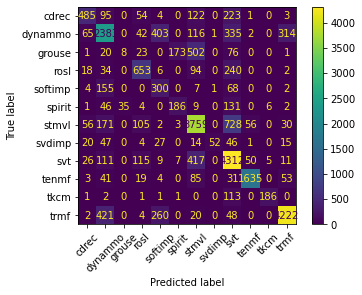

In [32]:
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, xticks_rotation=45)
plt.show()

In [33]:
scores

{'Accuracy': 0.7328684295388584,
 'F1-Score': 0.7233034204287266,
 'Precision': 0.7320464661668236,
 'Recall': 0.7328684295388584,
 'Hamming Loss': 0.26713157046114155}

### Per category


~~ Category: Biology ~~


{'Accuracy': 0.5435393258426966,
 'F1-Score': 0.5296348204955863,
 'Precision': 0.5224065098621112,
 'Recall': 0.5435393258426966,
 'Hamming Loss': 0.45646067415730335}

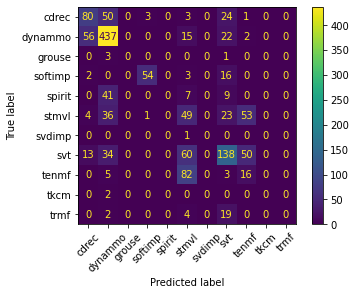


~~ Category: Climate ~~


{'Accuracy': 0.8542435424354243,
 'F1-Score': 0.8412880666969823,
 'Precision': 0.859948824594025,
 'Recall': 0.8542435424354243,
 'Hamming Loss': 0.14575645756457564}

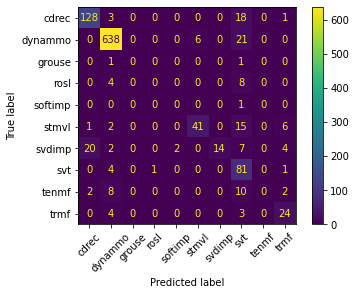


~~ Category: Medical ~~


{'Accuracy': 0.9439160380452607,
 'F1-Score': 0.9371346614437353,
 'Precision': 0.9459766437800086,
 'Recall': 0.9439160380452607,
 'Hamming Loss': 0.05608396195473926}

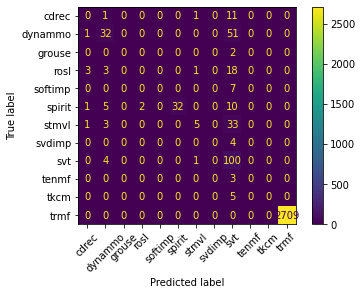


~~ Category: Motion ~~


{'Accuracy': 0.7321727485771677,
 'F1-Score': 0.711768052605617,
 'Precision': 0.7103253937517648,
 'Recall': 0.7321727485771677,
 'Hamming Loss': 0.26782725142283226}

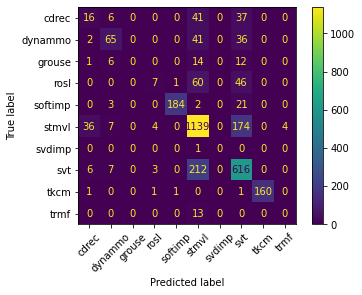


~~ Category: Other ~~


{'Accuracy': 0.7052866113024103,
 'F1-Score': 0.6925791770671016,
 'Precision': 0.7087378275502084,
 'Recall': 0.7052866113024103,
 'Hamming Loss': 0.2947133886975896}

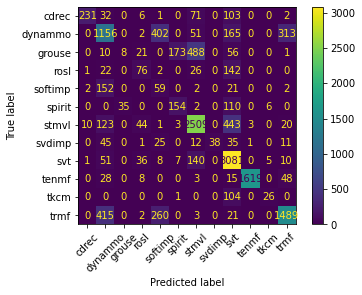


~~ Category: Power consumption ~~


{'Accuracy': 0.6757703081232493,
 'F1-Score': 0.6340916319082684,
 'Precision': 0.6368376989423161,
 'Recall': 0.6757703081232493,
 'Hamming Loss': 0.3242296918767507}

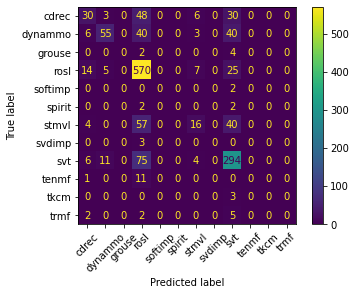


~~ Category: Water discharge ~~


{'Accuracy': 0.2,
 'F1-Score': 0.14,
 'Precision': 0.12,
 'Recall': 0.2,
 'Hamming Loss': 0.8}

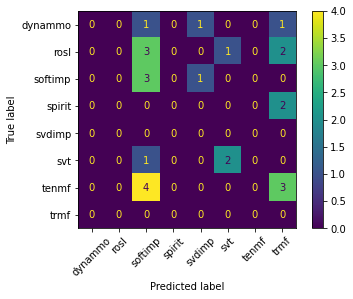

In [49]:
for category in np.unique(categories):
    ix = np.where(np.array(categories) == category)
    y_true_per_category = np.array(y_true)[ix].tolist()
    y_pred_per_category = np.array(y_pred)[ix].tolist()
    average_strat = 'weighted'
    scores_per_category = {
        'Accuracy': accuracy_score(y_true_per_category, y_pred_per_category, normalize=True, sample_weight=None), 
        'F1-Score': f1_score(y_true=y_true_per_category, y_pred=y_pred_per_category, average=average_strat, zero_division=0),
        'Precision': precision_score(y_true=y_true_per_category, y_pred=y_pred_per_category, average=average_strat, zero_division=0).tolist(), 
        'Recall': recall_score(y_true=y_true_per_category, y_pred=y_pred_per_category, average=average_strat, zero_division=0).tolist(),
        'Hamming Loss': hamming_loss(y_true_per_category, y_pred_per_category),
    }
    
    print('\n~~ Category: %s ~~' % category)
    display(scores_per_category)
    
    ConfusionMatrixDisplay.from_predictions(y_true=y_true_per_category, y_pred=y_pred_per_category, xticks_rotation=45)
    plt.show()